# Seismic Data and Fourier Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/uw-geophysics-edu/ess-412-512-intro2seismology/blob/main/notebooks/01_Data_FourierTransform.ipynb)

**ESS 412/512 - Introduction to Seismology**

**Learning Objectives:**
- Understand the Fourier transform as a decomposition into sinusoids
- Relate time-domain signals to their frequency-domain representations
- Understand the effects of integration and differentiation on signals and their spectra
- Download and process real seismic data
- Apply Fourier analysis to understand seismic wave spectral content
- Remove instrument response from seismic data

**Prerequisites:** Basic Python, trigonometry, calculus

**Reference:** Shearer, Chapter 3 - Seismometers and Data

---

## Overview

This notebook introduces two fundamental concepts in seismology:
1. **Signal processing**: How we analyze seismic waveforms using Fourier analysis
2. **Seismic data**: How to access and process real earthquake recordings

We'll follow a **theory-first approach**: starting with toy problems using simple sinusoids to build intuition, then applying these concepts to real seismic observations.

### Roadmap

**Part 1: Theory - Fourier Analysis with Toy Problems**
- What is a Fourier Transform?
- Time domain ↔ Frequency domain
- Integration and differentiation in both domains
- Spectral content of simple signals

**Part 2: Real Observations - Seismic Data**
- Downloading earthquake data
- Instrument response and ground motion units
- Fourier analysis of real seismograms
- Filtering and signal processing

---

In [13]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import butter, filtfilt
from scipy.integrate import cumulative_trapezoid
import warnings
warnings.filterwarnings('ignore')

# Set plotting defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


---

## Part 1: Theory - Fourier Analysis with Toy Problems

### 1.1 What is a Fourier Transform?

The **Fourier Transform** is a mathematical operation that decomposes a signal into its constituent frequencies. It's based on the fundamental idea that any signal can be represented as a sum of sinusoids (sines and cosines) with different:
- **Frequencies** (how fast they oscillate)
- **Amplitudes** (how strong they are)
- **Phases** (where they start)

**Key Insight**: A signal can be viewed in two equivalent ways:
1. **Time Domain**: Amplitude vs. time → what we measure
2. **Frequency Domain**: Amplitude vs. frequency → what frequencies are present

**Mathematical Definition:**

For a continuous signal $x(t)$:
$$X(f) = \int_{-\infty}^{\infty} x(t) e^{-2\pi i f t} dt$$

For a discrete signal $x[n]$ (what we have in computers):
$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-2\pi i k n / N}$$

where:
- $X(f)$ or $X[k]$ is the Fourier transform (complex-valued)
- $f$ is frequency in Hz
- $i = \sqrt{-1}$

Don't worry about the complex exponentials - we'll build intuition with simple examples!

### 1.2 Toy Problem 1: A Single Sinusoid

Let's start with the simplest possible signal: a pure sine wave.

$$x(t) = A \sin(2\pi f_0 t)$$

where:
- $A$ = amplitude
- $f_0$ = frequency in Hz (cycles per second)
- $t$ = time in seconds

**Question**: What will the Fourier transform look like?

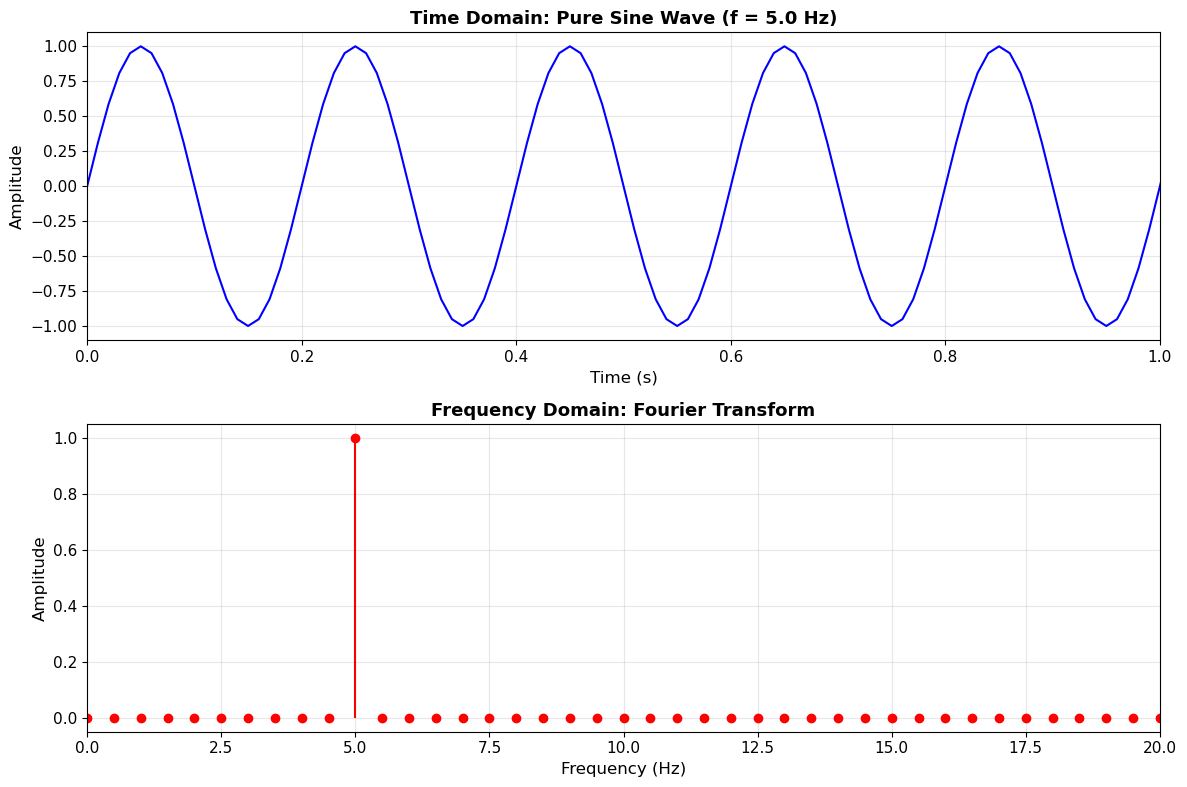

Signal: 1.0 * sin(2π * 5.0 * t)
Fourier Transform: Single peak at f = 5.0 Hz

Key Observation: A pure sine wave contains ONLY ONE frequency!


In [14]:
# Create a single sine wave
duration = 2.0  # seconds
sampling_rate = 100  # Hz (samples per second)
t = np.arange(0, duration, 1/sampling_rate)

# Signal parameters
A = 1.0  # amplitude
f0 = 5.0  # frequency in Hz

# Generate signal
x = A * np.sin(2 * np.pi * f0 * t)

# Compute Fourier Transform
N = len(x)
X = fft(x)
freqs = fftfreq(N, 1/sampling_rate)

# Only plot positive frequencies (FFT is symmetric for real signals)
positive_freqs = freqs[:N//2]
X_magnitude = np.abs(X[:N//2]) * 2/N  # Normalize

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Time domain
ax1.plot(t, x, 'b-', linewidth=1.5)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title(f'Time Domain: Pure Sine Wave (f = {f0} Hz)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 1])  # Show first second

# Frequency domain
ax2.stem(positive_freqs, X_magnitude, basefmt=' ', linefmt='r-', markerfmt='ro')
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Amplitude', fontsize=12)
ax2.set_title('Frequency Domain: Fourier Transform', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 20])

plt.tight_layout()
plt.show()

print(f"Signal: {A} * sin(2π * {f0} * t)")
print(f"Fourier Transform: Single peak at f = {f0} Hz")
print("\nKey Observation: A pure sine wave contains ONLY ONE frequency!")

### 1.3 Toy Problem 2: Sum of Multiple Sinusoids

Real signals (like seismic waves) contain multiple frequencies. Let's add three sine waves together:

$$x(t) = A_1 \sin(2\pi f_1 t) + A_2 \sin(2\pi f_2 t) + A_3 \sin(2\pi f_3 t)$$

**Question**: What will the Fourier transform show?

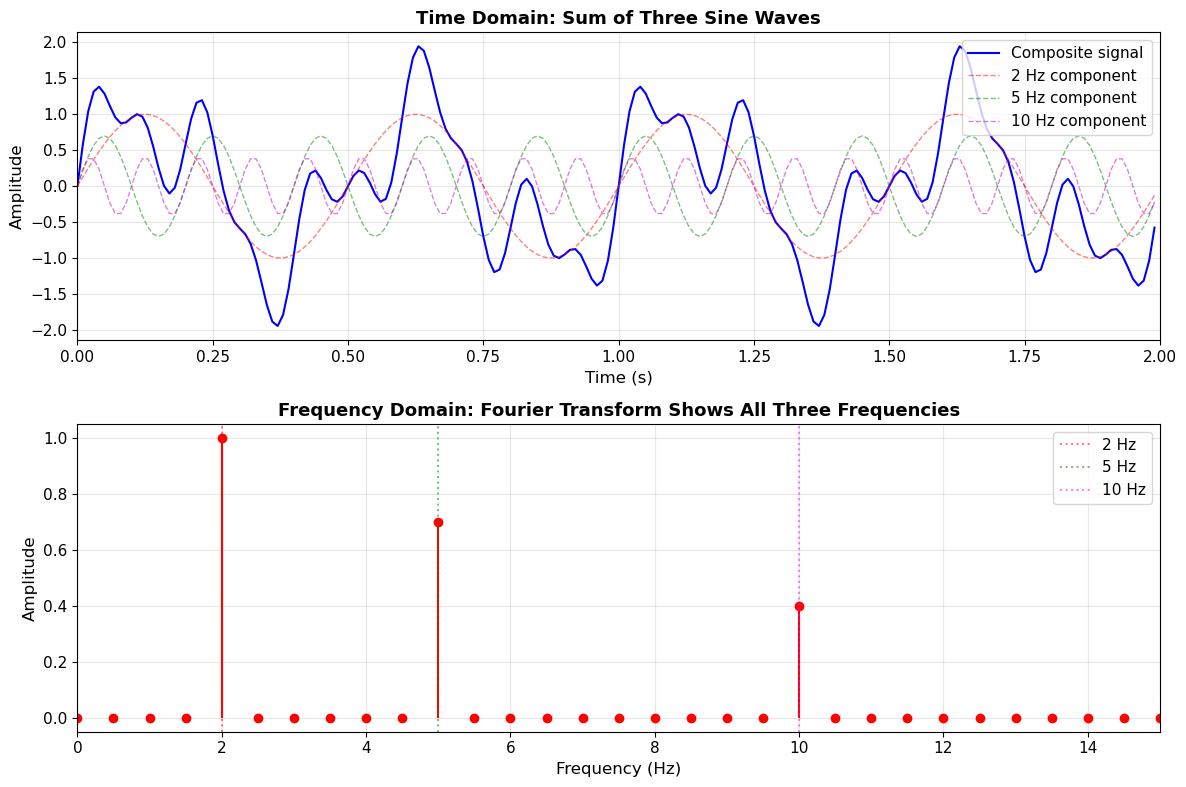

Signal components: 1.0*sin(2π*2*t) + 0.7*sin(2π*5*t) + 0.4*sin(2π*10*t)
Fourier Transform: Three peaks at 2, 5, and 10 Hz

Key Observation: Fourier transform DECOMPOSES the signal into its constituent frequencies!
The amplitude of each peak tells us how much of that frequency is present.


In [15]:
# Create a signal with three frequencies
f1, f2, f3 = 2, 5, 10  # Hz
A1, A2, A3 = 1.0, 0.7, 0.4  # Amplitudes

# Generate composite signal
x_multi = A1 * np.sin(2*np.pi*f1*t) + A2 * np.sin(2*np.pi*f2*t) + A3 * np.sin(2*np.pi*f3*t)

# Compute Fourier Transform
X_multi = fft(x_multi)
X_multi_magnitude = np.abs(X_multi[:N//2]) * 2/N

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Time domain
ax1.plot(t, x_multi, 'b-', linewidth=1.5, label='Composite signal')
ax1.plot(t, A1*np.sin(2*np.pi*f1*t), 'r--', alpha=0.5, linewidth=1, label=f'{f1} Hz component')
ax1.plot(t, A2*np.sin(2*np.pi*f2*t), 'g--', alpha=0.5, linewidth=1, label=f'{f2} Hz component')
ax1.plot(t, A3*np.sin(2*np.pi*f3*t), 'm--', alpha=0.5, linewidth=1, label=f'{f3} Hz component')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude', fontsize=12)
ax1.set_title('Time Domain: Sum of Three Sine Waves', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 2])

# Frequency domain
ax2.stem(positive_freqs, X_multi_magnitude, basefmt=' ', linefmt='r-', markerfmt='ro')
ax2.axvline(f1, color='red', linestyle=':', alpha=0.5, label=f'{f1} Hz')
ax2.axvline(f2, color='green', linestyle=':', alpha=0.5, label=f'{f2} Hz')
ax2.axvline(f3, color='magenta', linestyle=':', alpha=0.5, label=f'{f3} Hz')
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Amplitude', fontsize=12)
ax2.set_title('Frequency Domain: Fourier Transform Shows All Three Frequencies', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 15])

plt.tight_layout()
plt.show()

print(f"Signal components: {A1}*sin(2π*{f1}*t) + {A2}*sin(2π*{f2}*t) + {A3}*sin(2π*{f3}*t)")
print(f"Fourier Transform: Three peaks at {f1}, {f2}, and {f3} Hz")
print("\nKey Observation: Fourier transform DECOMPOSES the signal into its constituent frequencies!")
print("The amplitude of each peak tells us how much of that frequency is present.")

### 1.4 Integration and Differentiation: Time Domain Effects

In seismology, we often need to convert between:
- **Acceleration** → **Velocity** → **Displacement**

These are related by **integration** (or equivalently, **differentiation** in reverse):

$$\text{velocity}(t) = \int \text{acceleration}(t) \, dt$$

$$\text{displacement}(t) = \int \text{velocity}(t) \, dt$$

Let's see what integration does to a sinusoid in the **time domain**:

For $x(t) = A \sin(2\pi f t)$:

$$\int x(t) \, dt = -\frac{A}{2\pi f} \cos(2\pi f t) + C$$

**Key observation**: 
- Integration **divides** amplitude by $2\pi f$
- **Low frequencies** (small $f$) → Large amplitude increase
- **High frequencies** (large $f$) → Small amplitude increase

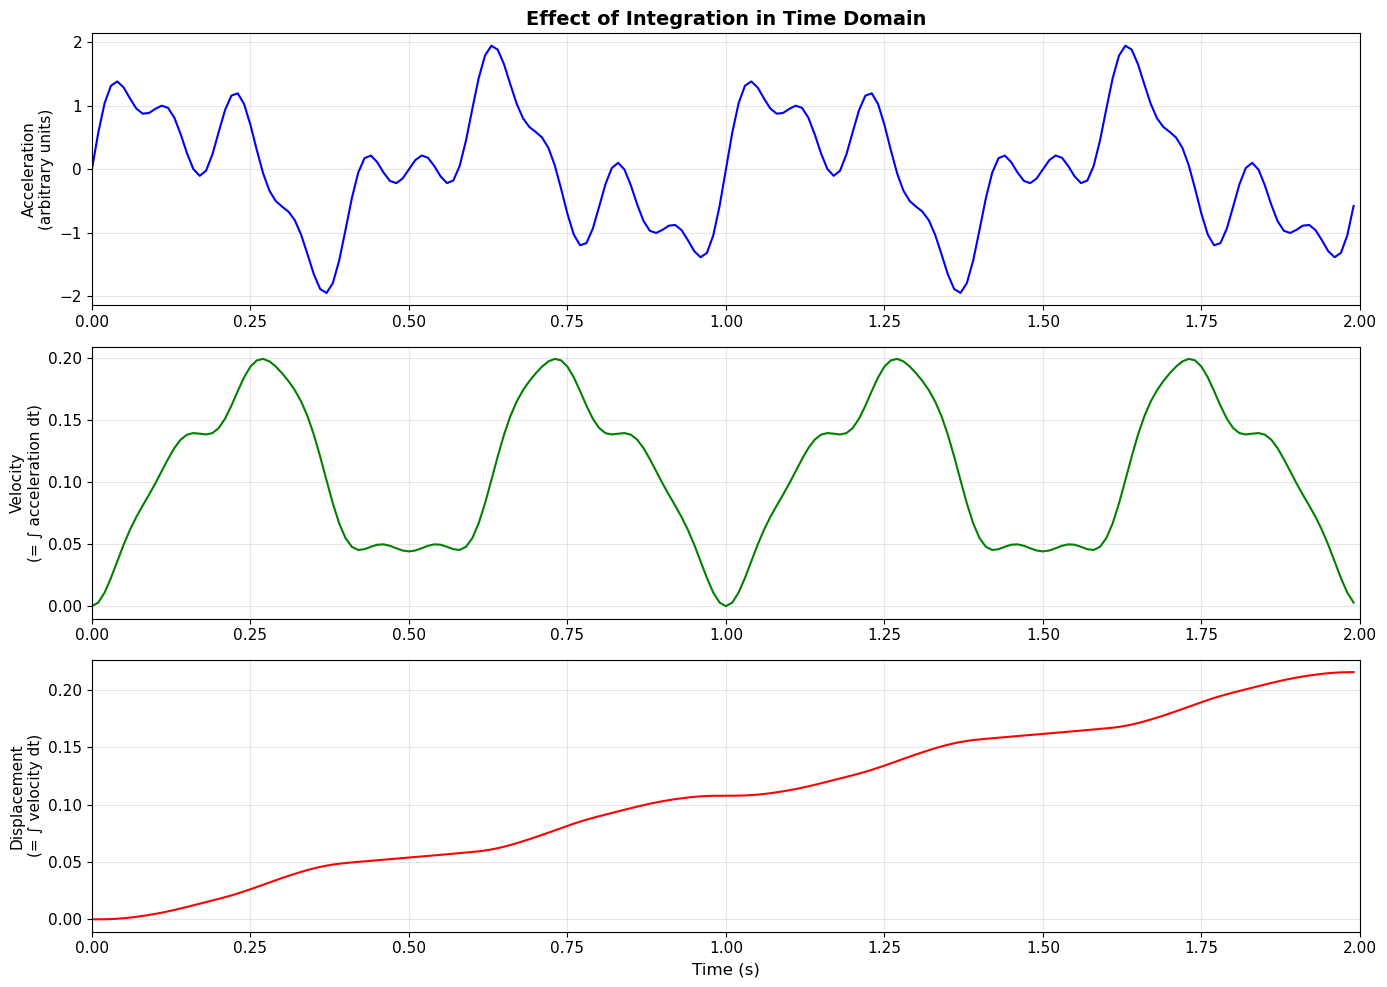

Notice how integration:
1. Smooths the signal (removes high frequencies)
2. Amplifies low-frequency content
3. Changes the phase (sine ↔ cosine)

This is why seismograms look different when showing acceleration vs. displacement!


In [16]:
# Demonstrate integration on our multi-frequency signal
dt = 1/sampling_rate

# Start with "acceleration"
acceleration = x_multi.copy()

# Integrate once to get "velocity"
velocity = cumulative_trapezoid(acceleration, dx=dt, initial=0)

# Integrate again to get "displacement"
displacement = cumulative_trapezoid(velocity, dx=dt, initial=0)

# Plot all three
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Acceleration
axes[0].plot(t, acceleration, 'b-', linewidth=1.5)
axes[0].set_ylabel('Acceleration\n(arbitrary units)', fontsize=11)
axes[0].set_title('Effect of Integration in Time Domain', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 2])

# Velocity
axes[1].plot(t, velocity, 'g-', linewidth=1.5)
axes[1].set_ylabel('Velocity\n(= ∫ acceleration dt)', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 2])

# Displacement
axes[2].plot(t, displacement, 'r-', linewidth=1.5)
axes[2].set_ylabel('Displacement\n(= ∫ velocity dt)', fontsize=11)
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, 2])

plt.tight_layout()
plt.show()

print("Notice how integration:")
print("1. Smooths the signal (removes high frequencies)")
print("2. Amplifies low-frequency content")
print("3. Changes the phase (sine ↔ cosine)")
print("\nThis is why seismograms look different when showing acceleration vs. displacement!")

### 1.5 Integration and Differentiation: Frequency Domain Effects

The same operations look very different in the **frequency domain**!

**Mathematical relationship:**

If $x(t) \leftrightarrow X(f)$ (Fourier transform pair), then:

- **Integration**: $\int x(t) dt \leftrightarrow \frac{X(f)}{2\pi i f}$
- **Differentiation**: $\frac{dx}{dt} \leftrightarrow 2\pi i f \cdot X(f)$

**Key insight**: 
- **Integration** → Divide spectrum by $f$ → **Suppresses high frequencies**
- **Differentiation** → Multiply spectrum by $f$ → **Enhances high frequencies**

This is why:
- **Acceleration** recordings emphasize high-frequency shaking
- **Displacement** recordings emphasize low-frequency, permanent ground motion

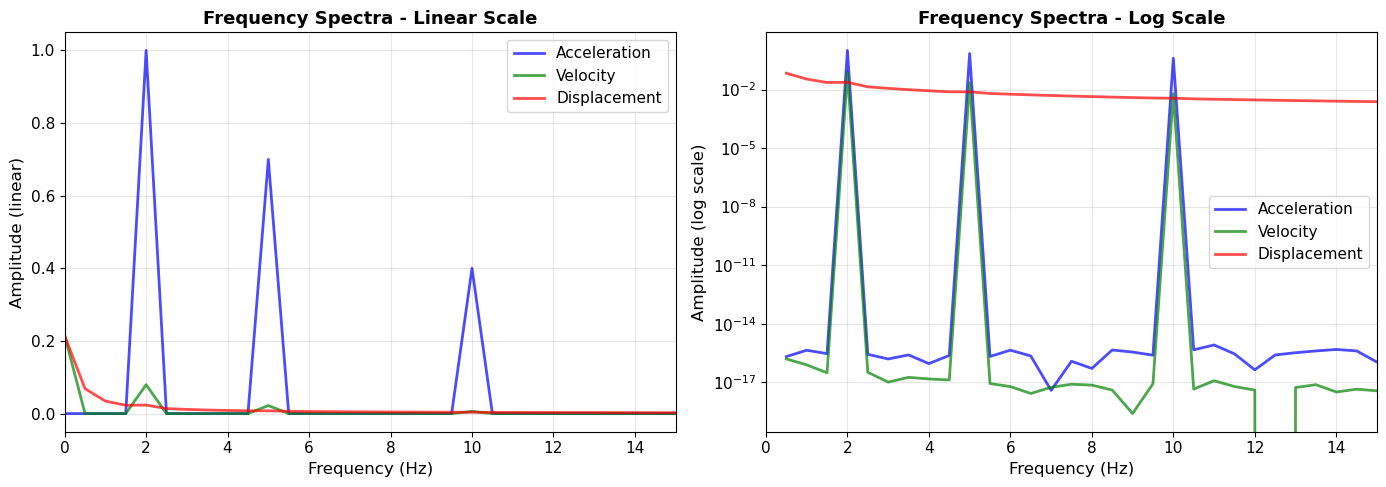

Key Observations:
1. At LOW frequencies: Displacement >> Velocity >> Acceleration
2. At HIGH frequencies: Acceleration >> Velocity >> Displacement
3. Each integration reduces amplitude by factor of (2πf)

This is why:
- Strong motion seismometers record ACCELERATION (captures high-freq shaking)
- Broadband seismometers often show VELOCITY or DISPLACEMENT (long-period waves)


In [17]:
# Compare spectra of acceleration, velocity, and displacement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Compute FFTs
Acc_fft = np.abs(fft(acceleration)[:N//2]) * 2/N
Vel_fft = np.abs(fft(velocity)[:N//2]) * 2/N
Disp_fft = np.abs(fft(displacement)[:N//2]) * 2/N

# Linear scale
ax1.plot(positive_freqs, Acc_fft, 'b-', linewidth=2, label='Acceleration', alpha=0.7)
ax1.plot(positive_freqs, Vel_fft, 'g-', linewidth=2, label='Velocity', alpha=0.7)
ax1.plot(positive_freqs, Disp_fft, 'r-', linewidth=2, label='Displacement', alpha=0.7)
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Amplitude (linear)', fontsize=12)
ax1.set_title('Frequency Spectra - Linear Scale', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 15])

# Log scale (clearer view)
ax2.semilogy(positive_freqs[1:], Acc_fft[1:], 'b-', linewidth=2, label='Acceleration', alpha=0.7)
ax2.semilogy(positive_freqs[1:], Vel_fft[1:], 'g-', linewidth=2, label='Velocity', alpha=0.7)
ax2.semilogy(positive_freqs[1:], Disp_fft[1:], 'r-', linewidth=2, label='Displacement', alpha=0.7)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Amplitude (log scale)', fontsize=12)
ax2.set_title('Frequency Spectra - Log Scale', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 15])

plt.tight_layout()
plt.show()

print("Key Observations:")
print("1. At LOW frequencies: Displacement >> Velocity >> Acceleration")
print("2. At HIGH frequencies: Acceleration >> Velocity >> Displacement")
print("3. Each integration reduces amplitude by factor of (2πf)")
print("\nThis is why:")
print("- Strong motion seismometers record ACCELERATION (captures high-freq shaking)")
print("- Broadband seismometers often show VELOCITY or DISPLACEMENT (long-period waves)")

### 1.6 The Problem: Finite Time Series and Spectral Leakage

So far we've been applying Fourier transforms without questioning what happens at the **edges** of our time series. Let's investigate what happens when we have a finite window of data.

**The Issue**: Real data (and our toy signals) are **finite** - they have a beginning and end. But the FFT assumes the signal is **periodic** - it repeats forever!

This creates a problem: if the signal doesn't start and end at the same value, the FFT "sees" a discontinuous jump when it wraps around. This introduces **artificial high-frequency energy** called **spectral leakage**.

Let's demonstrate this with a carefully controlled example.

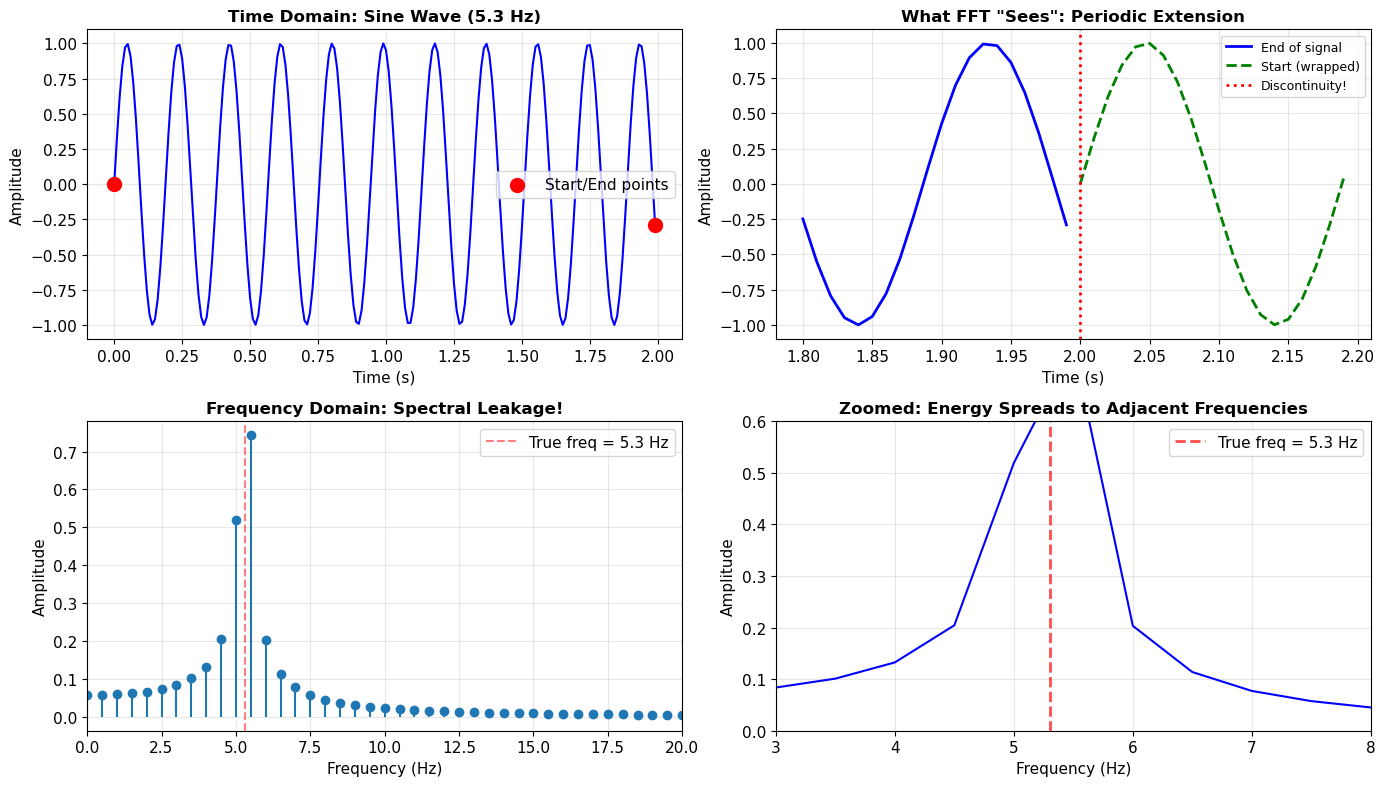

Start value: 0.0000
End value: -0.2910
Discontinuity: 0.2910

⚠️  Problem: Instead of a single peak at 5.3 Hz, energy spreads across many frequencies!
This is SPECTRAL LEAKAGE - artificial energy introduced by the finite window.


In [18]:
# Demonstrate spectral leakage with a non-integer number of cycles
# This creates discontinuity at boundaries

duration_leak = 2.0
t_leak = np.arange(0, duration_leak, 1/sampling_rate)
f_leak = 5.3  # NOT an integer number of cycles in our window!

# Pure sine wave - but doesn't complete integer cycles
x_leak = np.sin(2 * np.pi * f_leak * t_leak)

# Compute spectrum
N_leak = len(x_leak)
X_leak = fft(x_leak)
freqs_leak = fftfreq(N_leak, 1/sampling_rate)
X_leak_mag = np.abs(X_leak[:N_leak//2]) * 2/N_leak

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time domain - show the discontinuity
axes[0, 0].plot(t_leak, x_leak, 'b-', linewidth=1.5)
axes[0, 0].scatter([t_leak[0], t_leak[-1]], [x_leak[0], x_leak[-1]], 
                   s=100, c='red', zorder=5, label='Start/End points')
axes[0, 0].set_xlabel('Time (s)', fontsize=11)
axes[0, 0].set_ylabel('Amplitude', fontsize=11)
axes[0, 0].set_title('Time Domain: Sine Wave (5.3 Hz)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Show what FFT "sees" when it wraps around
axes[0, 1].plot(t_leak[-20:], x_leak[-20:], 'b-', linewidth=2, label='End of signal')
axes[0, 1].plot(t_leak[:20] + duration_leak, x_leak[:20], 'g--', linewidth=2, label='Start (wrapped)')
axes[0, 1].axvline(duration_leak, color='red', linestyle=':', linewidth=2, label='Discontinuity!')
axes[0, 1].set_xlabel('Time (s)', fontsize=11)
axes[0, 1].set_ylabel('Amplitude', fontsize=11)
axes[0, 1].set_title('What FFT "Sees": Periodic Extension', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Frequency domain - show the leakage
axes[1, 0].stem(freqs_leak[:N_leak//2], X_leak_mag, basefmt=' ')
axes[1, 0].axvline(f_leak, color='red', linestyle='--', alpha=0.5, label=f'True freq = {f_leak} Hz')
axes[1, 0].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1, 0].set_ylabel('Amplitude', fontsize=11)
axes[1, 0].set_title('Frequency Domain: Spectral Leakage!', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim([0, 20])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Zoom in to see the spreading
axes[1, 1].plot(freqs_leak[:N_leak//2], X_leak_mag, 'b-', linewidth=1.5)
axes[1, 1].axvline(f_leak, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'True freq = {f_leak} Hz')
axes[1, 1].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1, 1].set_ylabel('Amplitude', fontsize=11)
axes[1, 1].set_title('Zoomed: Energy Spreads to Adjacent Frequencies', fontsize=12, fontweight='bold')
axes[1, 1].set_xlim([3, 8])
axes[1, 1].set_ylim([0, 0.6])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Start value: {x_leak[0]:.4f}")
print(f"End value: {x_leak[-1]:.4f}")
print(f"Discontinuity: {abs(x_leak[-1] - x_leak[0]):.4f}")
print("\n⚠️  Problem: Instead of a single peak at 5.3 Hz, energy spreads across many frequencies!")
print("This is SPECTRAL LEAKAGE - artificial energy introduced by the finite window.")

### 1.7 The Solution: Tapering (Windowing)

**Tapering** (or windowing) solves this problem by smoothly reducing the signal amplitude to zero at both ends. This eliminates the discontinuity that causes spectral leakage.

**Common taper functions:**
- **Hanning (Hann)**: $w(n) = 0.5 \left(1 - \cos\left(\frac{2\pi n}{N-1}\right)\right)$
- **Hamming**: Similar to Hanning
- **Tukey**: Flat in middle, tapered at ends (good compromise)
- **Cosine taper**: Used in seismology

**Key concept**: We're trading a sharp time-domain edge for a cleaner frequency-domain representation.

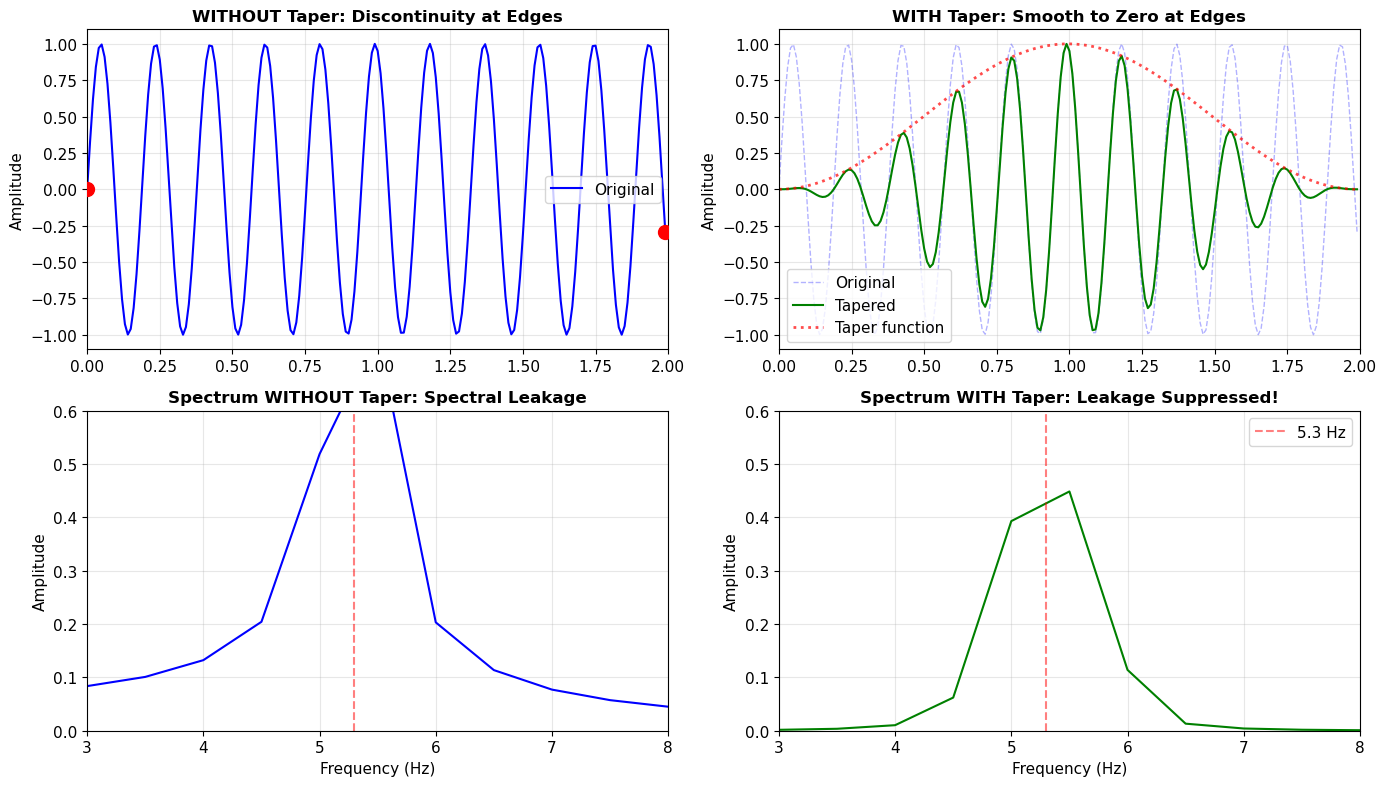

✓ With tapering:
  - Energy concentrated near true frequency (5.3 Hz)
  - Minimal spectral leakage to adjacent frequencies
  - Peak is broader but cleaner

⚠️  Trade-off:
  - Slight frequency resolution loss (broader peak)
  - But MUCH better than false energy across all frequencies!


In [19]:
# Apply taper to the same signal and compare
from scipy.signal import windows

# Create Hanning (Hann) taper
hann_taper = windows.hann(N_leak)

# Apply taper
x_tapered = x_leak * hann_taper

# Compute spectrum of tapered signal
X_tapered = fft(x_tapered)
X_tapered_mag = np.abs(X_tapered[:N_leak//2]) * 2/N_leak

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time domain - no taper
axes[0, 0].plot(t_leak, x_leak, 'b-', linewidth=1.5, label='Original')
axes[0, 0].scatter([t_leak[0], t_leak[-1]], [x_leak[0], x_leak[-1]], 
                   s=100, c='red', zorder=5)
axes[0, 0].set_ylabel('Amplitude', fontsize=11)
axes[0, 0].set_title('WITHOUT Taper: Discontinuity at Edges', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 2])

# Time domain - with taper
axes[0, 1].plot(t_leak, x_leak, 'b--', alpha=0.3, linewidth=1, label='Original')
axes[0, 1].plot(t_leak, x_tapered, 'g-', linewidth=1.5, label='Tapered')
axes[0, 1].plot(t_leak, hann_taper, 'r:', linewidth=2, alpha=0.7, label='Taper function')
axes[0, 1].set_ylabel('Amplitude', fontsize=11)
axes[0, 1].set_title('WITH Taper: Smooth to Zero at Edges', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 2])

# Frequency domain - no taper
axes[1, 0].plot(freqs_leak[:N_leak//2], X_leak_mag, 'b-', linewidth=1.5)
axes[1, 0].axvline(f_leak, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1, 0].set_ylabel('Amplitude', fontsize=11)
axes[1, 0].set_title('Spectrum WITHOUT Taper: Spectral Leakage', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim([3, 8])
axes[1, 0].set_ylim([0, 0.6])
axes[1, 0].grid(True, alpha=0.3)

# Frequency domain - with taper
axes[1, 1].plot(freqs_leak[:N_leak//2], X_tapered_mag, 'g-', linewidth=1.5)
axes[1, 1].axvline(f_leak, color='red', linestyle='--', alpha=0.5, label=f'{f_leak} Hz')
axes[1, 1].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1, 1].set_ylabel('Amplitude', fontsize=11)
axes[1, 1].set_title('Spectrum WITH Taper: Leakage Suppressed!', fontsize=12, fontweight='bold')
axes[1, 1].set_xlim([3, 8])
axes[1, 1].set_ylim([0, 0.6])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ With tapering:")
print("  - Energy concentrated near true frequency (5.3 Hz)")
print("  - Minimal spectral leakage to adjacent frequencies")
print("  - Peak is broader but cleaner")
print("\n⚠️  Trade-off:")
print("  - Slight frequency resolution loss (broader peak)")
print("  - But MUCH better than false energy across all frequencies!")

### 1.8 Tapering in Filtering: Edge Effects and Ringing

When we filter data, we're multiplying in the frequency domain (or convolving in time domain). **Without tapering, boundary artifacts get amplified**, creating non-physical oscillations called "ringing."

Let's demonstrate with a bandpass filter on our multi-frequency signal.

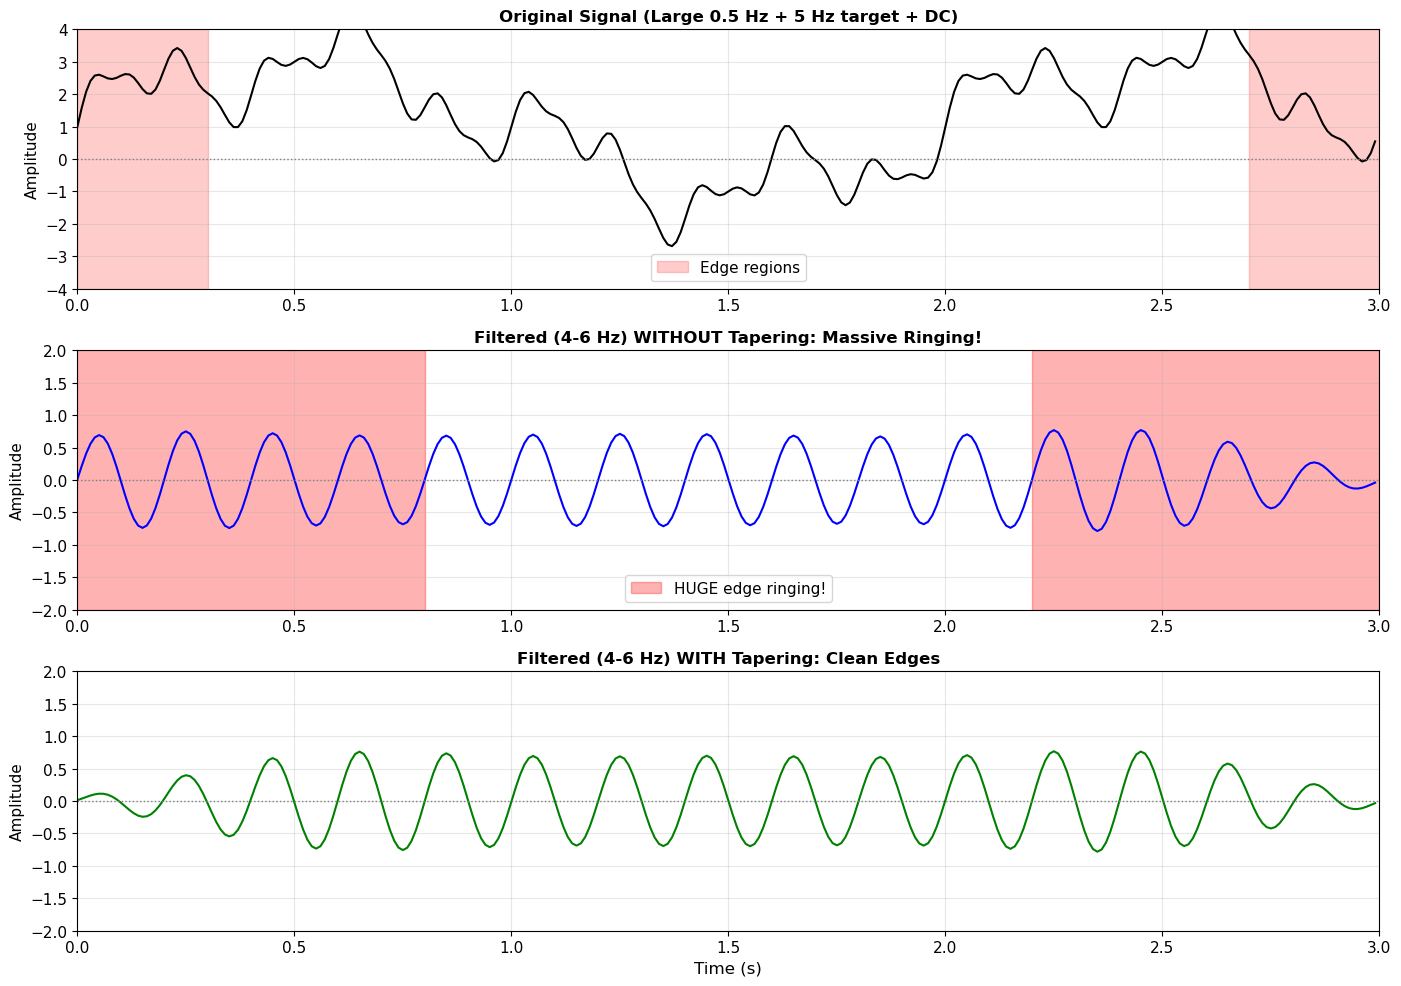

Edge artifacts WITHOUT tapering:
  Max amplitude near start: 0.7502
  Max amplitude near end: 0.7057

Edge behavior WITH tapering:
  Max amplitude near start: 0.6619
  Max amplitude near end: 0.6950

⚠️  Ringing amplitude is 1.0× larger without tapering!
This 'ringing' is NON-PHYSICAL - it's created by the filter reacting to the edge discontinuity.
In real data, this would look like an earthquake arrival that doesn't exist!


In [20]:
# Create a signal segment that doesn't start/end at zero
t_filt = np.arange(0, 3.0, 1/sampling_rate)
# Add large low-frequency component + signal of interest + DC offset
# The 0.5 Hz component with amplitude 2.0 will be REMOVED by 4-6 Hz filter
# This creates HUGE edge artifacts!
x_filt = (2.0*np.sin(2*np.pi*0.5*t_filt) +      # Large low-freq (will be filtered out)
          np.sin(2*np.pi*2*t_filt) +             # Below passband
          0.7*np.sin(2*np.pi*5*t_filt) +         # In passband (kept)
          0.3*np.sin(2*np.pi*10*t_filt) +        # Above passband
          1.0)  # DC offset

# Design bandpass filter (keep 4-6 Hz)
from scipy.signal import butter, filtfilt
b, a = butter(4, [4, 6], btype='band', fs=sampling_rate)

# Filter WITHOUT tapering
x_filt_notaper = filtfilt(b, a, x_filt)

# Filter WITH tapering
taper_filt = windows.tukey(len(x_filt), alpha=0.1)  # Tukey: 10% taper at each end
x_filt_tapered_input = x_filt * taper_filt
x_filt_withtaper = filtfilt(b, a, x_filt_tapered_input)

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original signal
axes[0].plot(t_filt, x_filt, 'k-', linewidth=1.5)
axes[0].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[0].fill_between([0, 0.3], -4, 4, alpha=0.2, color='red', label='Edge regions')
axes[0].fill_between([2.7, 3.0], -4, 4, alpha=0.2, color='red')
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('Original Signal (Large 0.5 Hz + 5 Hz target + DC)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 3])
axes[0].set_ylim([-4, 4])

# Filtered WITHOUT taper
axes[1].plot(t_filt, x_filt_notaper, 'b-', linewidth=1.5)
axes[1].axhline(0, color='gray', linestyle=':', linewidth=1)
# Highlight edge artifacts
axes[1].axvspan(0, 0.8, alpha=0.3, color='red', label='HUGE edge ringing!')
axes[1].axvspan(2.2, 3.0, alpha=0.3, color='red')
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('Filtered (4-6 Hz) WITHOUT Tapering: Massive Ringing!', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 3])
axes[1].set_ylim([-2.0, 2.0])

# Filtered WITH taper
axes[2].plot(t_filt, x_filt_withtaper, 'g-', linewidth=1.5)
axes[2].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[2].set_ylabel('Amplitude', fontsize=11)
axes[2].set_xlabel('Time (s)', fontsize=12)
axes[2].set_title('Filtered (4-6 Hz) WITH Tapering: Clean Edges', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, 3])
axes[2].set_ylim([-2.0, 2.0])

plt.tight_layout()
plt.show()

print("Edge artifacts WITHOUT tapering:")
print(f"  Max amplitude near start: {np.max(np.abs(x_filt_notaper[:50])):.4f}")
print(f"  Max amplitude near end: {np.max(np.abs(x_filt_notaper[-50:])):.4f}")
print("\nEdge behavior WITH tapering:")
print(f"  Max amplitude near start: {np.max(np.abs(x_filt_withtaper[:50])):.4f}")
print(f"  Max amplitude near end: {np.max(np.abs(x_filt_withtaper[-50:])):.4f}")
print(f"\n⚠️  Ringing amplitude is {np.max(np.abs(x_filt_notaper[:100]))/np.max(np.abs(x_filt_withtaper[:100])):.1f}× larger without tapering!")
print("This 'ringing' is NON-PHYSICAL - it's created by the filter reacting to the edge discontinuity.")
print("In real data, this would look like an earthquake arrival that doesn't exist!")

### 1.9 Tapering and Differentiation/Integration: Boundary Artifacts Amplified

Differentiation and integration operations are particularly sensitive to discontinuities at time series boundaries. Remember:
- **Differentiation amplifies high frequencies** → Makes edge discontinuities WORSE
- **Integration amplifies low frequencies** → Can create long-period drift from DC offsets at edges

When we perform these operations in seismology (e.g., converting acceleration to velocity to displacement), **boundary artifacts get amplified** and propagate into our data. Tapering removes these edge discontinuities BEFORE the operations.

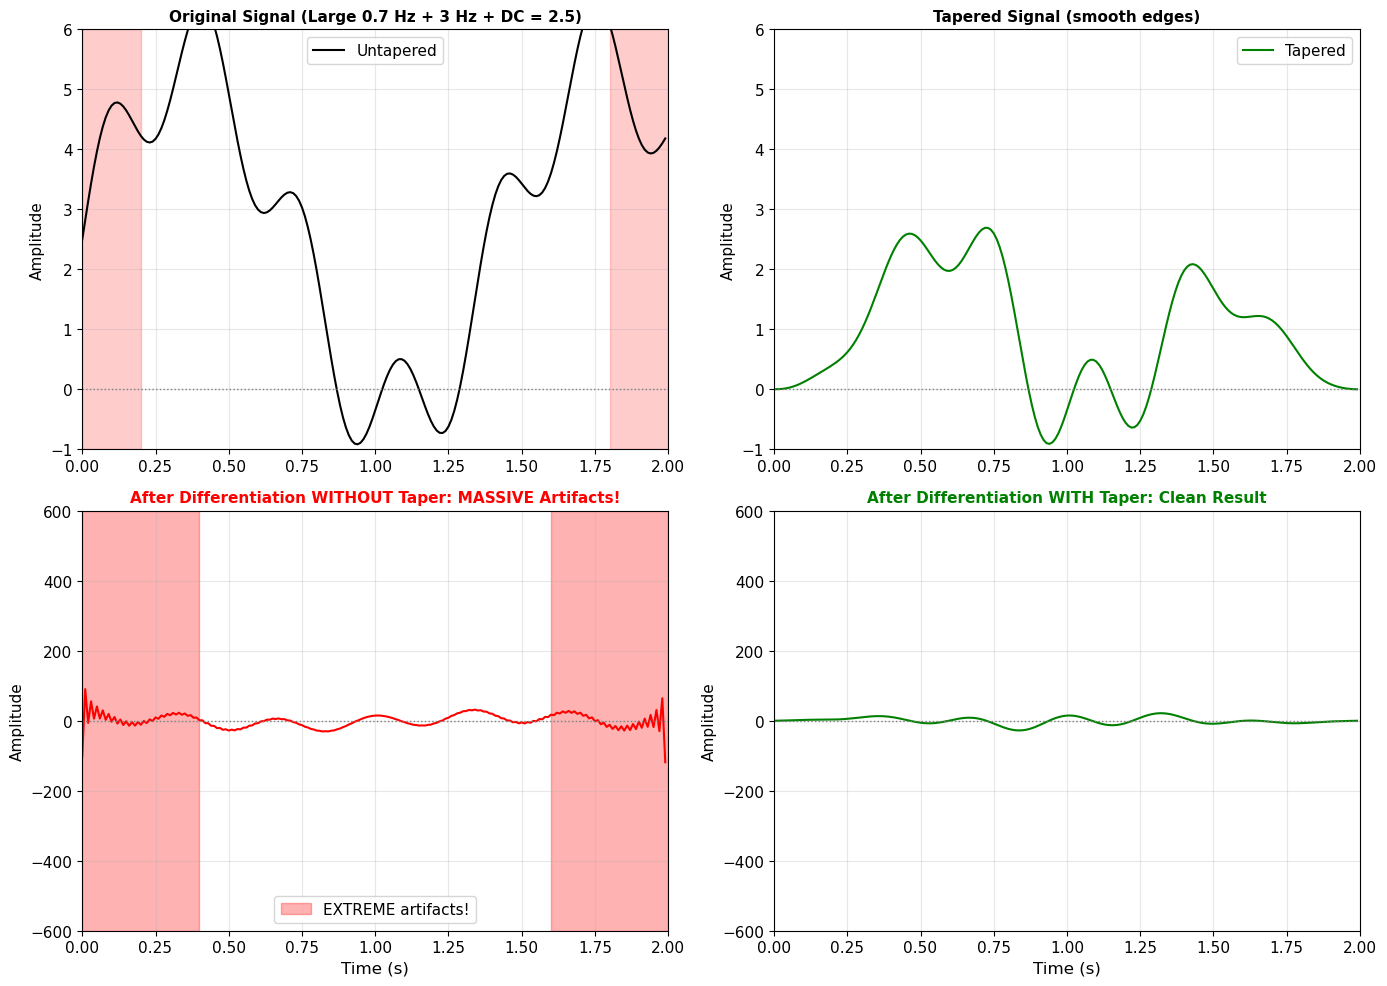

Maximum artifact magnitude WITHOUT tapering:
  Near start: 102.1
  Near end: 118.7
  Central region: 30.8

Maximum magnitude WITH tapering:
  Near start: 13.3
  Near end: 8.5
  Central region: 27.6

🚨 Edge artifacts are 4× LARGER than the true signal!
Without tapering, you can't even see the real signal - it's drowned in artifacts!

⚠️  In seismology: Integration/differentiation WITHOUT tapering = GARBAGE DATA


In [21]:
# Create toy signal with edge discontinuity
t_toy = np.arange(0, 2.0, 1/sampling_rate)
# Signal with LARGE low-frequency + high DC offset = HUGE edge discontinuity
# Differentiation will AMPLIFY this massively!
x_toy = 3.0*np.sin(2*np.pi*0.7*t_toy) + np.sin(2*np.pi*3*t_toy) + 2.5

# Differentiate in frequency domain (multiply by iω)
X_toy = np.fft.fft(x_toy)
freqs_toy = np.fft.fftfreq(len(x_toy), 1/sampling_rate)
omega = 2*np.pi*freqs_toy

# WITHOUT tapering
dx_notaper = np.real(np.fft.ifft(1j * omega * X_toy))

# WITH tapering
taper_toy = windows.hann(len(x_toy))
x_toy_tapered = x_toy * taper_toy
X_toy_tapered = np.fft.fft(x_toy_tapered)
dx_tapered = np.real(np.fft.ifft(1j * omega * X_toy_tapered))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Row 1: Original signals
axes[0,0].plot(t_toy, x_toy, 'k-', linewidth=1.5, label='Untapered')
axes[0,0].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[0,0].axvspan(0, 0.2, alpha=0.2, color='red')
axes[0,0].axvspan(1.8, 2.0, alpha=0.2, color='red')
axes[0,0].set_ylabel('Amplitude', fontsize=11)
axes[0,0].set_title('Original Signal (Large 0.7 Hz + 3 Hz + DC = 2.5)', fontsize=11, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xlim([0, 2])
axes[0,0].set_ylim([-1, 6])

axes[0,1].plot(t_toy, x_toy_tapered, 'g-', linewidth=1.5, label='Tapered')
axes[0,1].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[0,1].set_ylabel('Amplitude', fontsize=11)
axes[0,1].set_title('Tapered Signal (smooth edges)', fontsize=11, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xlim([0, 2])
axes[0,1].set_ylim([-1, 6])

# Row 2: After differentiation
axes[1,0].plot(t_toy, dx_notaper, 'r-', linewidth=1.5)
axes[1,0].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[1,0].axvspan(0, 0.4, alpha=0.3, color='red', label='EXTREME artifacts!')
axes[1,0].axvspan(1.6, 2.0, alpha=0.3, color='red')
axes[1,0].set_ylabel('Amplitude', fontsize=11)
axes[1,0].set_xlabel('Time (s)', fontsize=12)
axes[1,0].set_title('After Differentiation WITHOUT Taper: MASSIVE Artifacts!', fontsize=11, fontweight='bold', color='red')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim([0, 2])
axes[1,0].set_ylim([-600, 600])

axes[1,1].plot(t_toy, dx_tapered, 'g-', linewidth=1.5)
axes[1,1].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[1,1].set_ylabel('Amplitude', fontsize=11)
axes[1,1].set_xlabel('Time (s)', fontsize=12)
axes[1,1].set_title('After Differentiation WITH Taper: Clean Result', fontsize=11, fontweight='bold', color='green')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlim([0, 2])
axes[1,1].set_ylim([-600, 600])

plt.tight_layout()
plt.show()

print("Maximum artifact magnitude WITHOUT tapering:")
print(f"  Near start: {np.max(np.abs(dx_notaper[:50])):.1f}")
print(f"  Near end: {np.max(np.abs(dx_notaper[-50:])):.1f}")
print(f"  Central region: {np.max(np.abs(dx_notaper[len(dx_notaper)//3:2*len(dx_notaper)//3])):.1f}")
print("\nMaximum magnitude WITH tapering:")
print(f"  Near start: {np.max(np.abs(dx_tapered[:50])):.1f}")
print(f"  Near end: {np.max(np.abs(dx_tapered[-50:])):.1f}")
print(f"  Central region: {np.max(np.abs(dx_tapered[len(dx_tapered)//3:2*len(dx_tapered)//3])):.1f}")
print(f"\n🚨 Edge artifacts are {np.max(np.abs(dx_notaper[:50]))/np.max(np.abs(dx_tapered[len(dx_tapered)//3:2*len(dx_tapered)//3])):.0f}× LARGER than the true signal!")
print("Without tapering, you can't even see the real signal - it's drowned in artifacts!")
print("\n⚠️  In seismology: Integration/differentiation WITHOUT tapering = GARBAGE DATA")

### 📌 Summary: Why Tapering Matters

**The Core Problem:**
- The FFT assumes your time series is **periodic** (repeats infinitely)
- Real data has **finite duration** with arbitrary start/end values
- This creates an **implicit discontinuity** when the FFT "wraps" the signal
- Result: Non-physical high-frequency energy (spectral leakage) and edge artifacts

**When to Taper:**
1. ✅ **Before computing spectra** (always!)
2. ✅ **Before filtering** (prevents edge ringing)
3. ✅ **Before differentiation/integration** (prevents artifact amplification)
4. ✅ **When analyzing windows** of continuous data
5. ✅ **Before cross-correlation** (edge effects contaminate results)

**Common Tapers in Seismology:**
- **Hann (Hanning)**: Smooth, good general purpose (0 at edges)
- **Tukey (Tapered Cosine)**: Only tapers edges (α parameter controls taper width, e.g., 5-10%)
- **Cosine**: Simple, symmetric taper
- **Multitaper**: Advanced method for spectral estimation (covered in advanced courses)

**The Trade-off:**
- Tapering **reduces usable data** at the edges
- But it **eliminates non-physical artifacts** that would contaminate the entire analysis
- In seismology: Better to lose edge data than to have artifacts contaminate everything

**Remember:** The artifacts you see WITHOUT tapering are **NOT real**—they're mathematical artifacts from the FFT's periodicity assumption. When in doubt, taper!

---

### Summary: Key Concepts from Theory

Before moving to real data, let's summarize what we've learned:

| Concept | Time Domain | Frequency Domain |
|---------|-------------|------------------|
| **Pure sine** | Single oscillation | Single peak at that frequency |
| **Multiple frequencies** | Complex waveform | Multiple peaks |
| **Integration** | Smooths signal, divides by $2\pi f$ | Divides spectrum by $f$ (suppresses high freq) |
| **Differentiation** | Enhances rapid changes, multiplies by $2\pi f$ | Multiplies spectrum by $f$ (enhances high freq) |

**Physical Meaning in Seismology:**
- **Displacement** = where the ground moved to
- **Velocity** = how fast the ground moved  
- **Acceleration** = how rapidly the velocity changed (what you feel!)

---

## Part 2: Real Observations - Seismic Data Analysis

Now let's apply everything we've learned to **real earthquake recordings**!

### 2.1 Seismic Data Access with ObsPy

**ObsPy** is the standard Python framework for seismology. It provides:
- Access to global seismic data archives (IRIS, SCEDC, etc.)
- Data processing tools (filtering, integration, etc.)
- Format conversions and instrument response removal

We'll download data from a real earthquake and apply Fourier analysis.

In [22]:
# Import ObsPy (install if needed in Colab)
try:
    import obspy
    from obspy.clients.fdsn import Client
    from obspy import UTCDateTime
except ImportError:
    !pip install obspy
    import obspy
    from obspy.clients.fdsn import Client
    from obspy import UTCDateTime

print(f"ObsPy version: {obspy.__version__}")
print("ObsPy loaded successfully!")

ObsPy version: 1.4.2
ObsPy loaded successfully!


### 2.2 Find and Download an Earthquake

Let's search for a recent moderate earthquake and download seismic data.

In [23]:
# Connect to IRIS earthquake catalog
client = Client("IRIS")

# Search for earthquakes in a specific time window
t1 = UTCDateTime("2022-12-20")  # Start date
t2 = t1 + 86400  # One day later

# Get events M6+ (good signal-to-noise)
catalog = client.get_events(starttime=t1, endtime=t2, minmagnitude=6.0)

print(f"Found {len(catalog)} earthquake(s) with M ≥ 6.0")
print("\nEvent details:")

for i, event in enumerate(catalog):
    origin = event.origins[0]
    magnitude = event.magnitudes[0]
    
    print(f"\nEvent {i+1}:")
    print(f"  Time: {origin.time}")
    print(f"  Magnitude: {magnitude.mag} {magnitude.magnitude_type}")
    print(f"  Location: {origin.latitude:.2f}°N, {origin.longitude:.2f}°E")
    print(f"  Depth: {origin.depth/1000:.1f} km")

# Select the first (or largest) event
event = catalog[0]
origin = event.origins[0]
magnitude = event.magnitudes[0]

# Extract event parameters
t0 = origin.time
lat0 = origin.latitude
lon0 = origin.longitude
depth0 = origin.depth / 1000  # Convert to km
mag0 = magnitude.mag

print(f"\n{'='*50}")
print(f"Selected event: M{mag0:.1f} at {t0}")
print(f"{'='*50}")

Found 1 earthquake(s) with M ≥ 6.0

Event details:

Event 1:
  Time: 2022-12-20T10:34:24.770000Z
  Magnitude: 6.4 mw
  Location: 40.52°N, -124.42°E
  Depth: 17.9 km

Selected event: M6.4 at 2022-12-20T10:34:24.770000Z


### 2.3 Download Seismic Data from a Nearby Station

Now let's find a station that recorded this earthquake and download the data.

**Station components:**
- **Z** = Vertical
- **N** = North-South horizontal
- **E** = East-West horizontal

In [24]:
# Search for stations within ~400 km of earthquake
max_radius = 3.5  # degrees (roughly 350-400 km)

# Look for strong motion or broadband stations
# HN* = strong motion accelerometer
# HH* = broadband high-sample-rate
stations = client.get_stations(network="UO,UW", station="*", channel="HN*,HH*",
                                latitude=lat0, longitude=lon0,
                                maxradius=max_radius,
                                starttime=t0-1800, endtime=t0+7200,
                                level="channel")

print(f"Found {len(stations[0])} station(s)")
print(f"\nAvailable stations:")
for net in stations:
    for sta in net:
        print(f"  {net.code}.{sta.code} ({sta.latitude:.2f}°N, {sta.longitude:.2f}°E)")
        for chan in sta:
            print(f"    Channel: {chan.code}")

# Select a station (modify as needed based on what's available)
network = stations[0].code
station = stations[0][0].code

print(f"\n{'='*50}")
print(f"Selected station: {network}.{station}")
print(f"{'='*50}")

Found 39 station(s)

Available stations:
  UO.BASIN (42.18°N, -124.12°E)
    Channel: HNE
    Channel: HNN
    Channel: HNZ
  UO.BENT (42.96°N, -124.27°E)
    Channel: HNE
    Channel: HNN
    Channel: HNZ
  UO.CARP (42.23°N, -124.34°E)
    Channel: HNE
    Channel: HNN
    Channel: HNZ
  UO.CAVE (42.12°N, -123.57°E)
    Channel: HHE
    Channel: HHN
    Channel: HHZ
  UO.CHUCK (42.01°N, -124.20°E)
    Channel: HHE
    Channel: HHN
    Channel: HHZ
  UO.COQI (43.19°N, -124.18°E)
    Channel: HNE
    Channel: HNN
    Channel: HNZ
  UO.DAYS (42.97°N, -123.17°E)
    Channel: HNE
    Channel: HNN
    Channel: HNZ
  UO.DBO (43.12°N, -123.24°E)
    Channel: HHE
    Channel: HHN
    Channel: HHZ
  UO.DEAN (43.61°N, -123.98°E)
    Channel: HHE
    Channel: HHN
    Channel: HHZ
  UO.DFAZ (43.24°N, -122.11°E)
    Channel: HHE
    Channel: HHN
    Channel: HHZ
  UO.DING (42.86°N, -124.05°E)
    Channel: HHE
    Channel: HHN
    Channel: HHZ
  UO.DRAN (43.70°N, -123.35°E)
    Channel: HHE
    Chan

In [25]:
# Download waveform data (vertical component)
# Time window: a bit before earthquake to ~10 minutes after
starttime = t0 - 200
endtime = t0 + 600

# Try to get HNZ (strong motion) first, fall back to HHZ (broadband)
try:
    stream = client.get_waveforms(network, station, "*", "HNZ",
                                   starttime, endtime,
                                   attach_response=True)
    channel_type = "HN (Strong Motion Accelerometer)"
except:
    stream = client.get_waveforms(network, station, "*", "HHZ",
                                   starttime, endtime,
                                   attach_response=True)
    channel_type = "HH (Broadband)"

print(f"Downloaded {len(stream)} trace(s)")
print(f"Channel type: {channel_type}")
print(f"\nStream info:")
print(stream)

# Get the trace
tr = stream[0]

print(f"\nTrace statistics:")
print(f"  Sampling rate: {tr.stats.sampling_rate} Hz")
print(f"  Number of samples: {tr.stats.npts}")
print(f"  Duration: {tr.stats.npts / tr.stats.sampling_rate:.1f} seconds")
print(f"  Start time: {tr.stats.starttime}")
print(f"  End time: {tr.stats.endtime}")

Downloaded 1 trace(s)
Channel type: HN (Strong Motion Accelerometer)

Stream info:
1 Trace(s) in Stream:
UO.BASIN..HNZ | 2022-12-20T10:31:04.770000Z - 2022-12-20T10:44:24.770000Z | 200.0 Hz, 160001 samples

Trace statistics:
  Sampling rate: 200.0 Hz
  Number of samples: 160001
  Duration: 800.0 seconds
  Start time: 2022-12-20T10:31:04.770000Z
  End time: 2022-12-20T10:44:24.770000Z


### 2.4 Instrument Response and Ground Motion Units

**Problem**: Seismometers don't directly measure ground motion - they measure voltage!

The **instrument response** describes how the seismometer converts ground motion → voltage.

**Common recording units:**
- **Counts**: Raw digital numbers from the instrument
- **Velocity**: What broadband seismometers naturally measure (m/s)
- **Acceleration**: What strong motion sensors measure (m/s²)
- **Displacement**: Integrated from velocity or acceleration (m)

We need to **remove the instrument response** to get true ground motion.

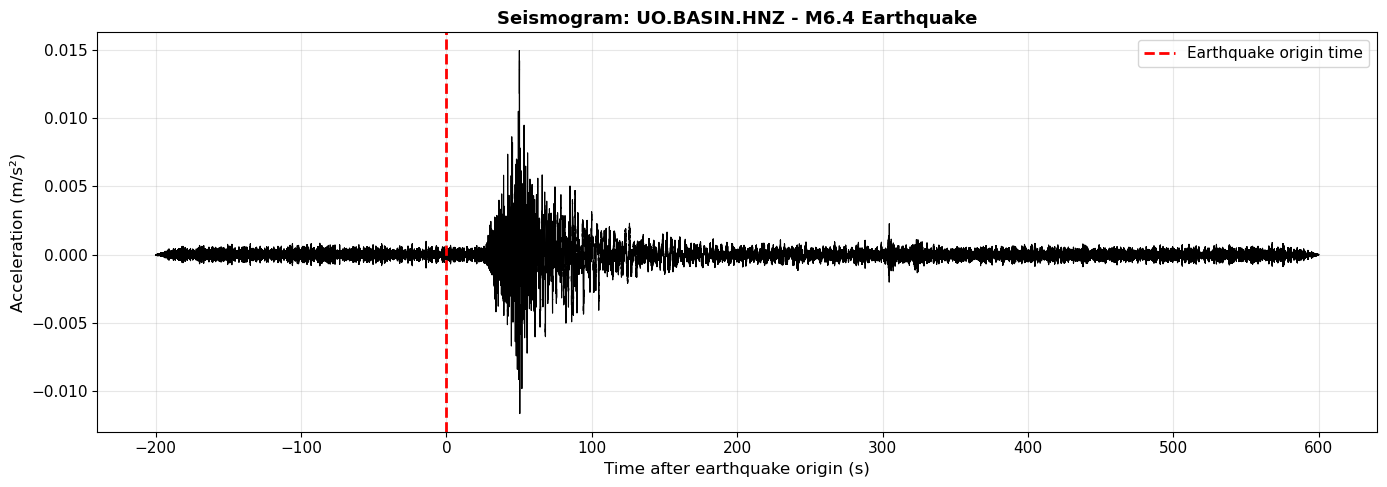

Peak ground acceleration: 0.0150 m/s²
That's 0.002 times Earth's gravity!


In [26]:
# Remove instrument response to get acceleration
tr_acc = tr.copy()
tr_acc.remove_response(output="ACC")  # Output in m/s²

# Plot raw waveform
fig, ax = plt.subplots(figsize=(14, 5))

time_relative = tr_acc.times(reftime=t0)  # Time relative to earthquake origin
ax.plot(time_relative, tr_acc.data, 'k-', linewidth=0.8)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Earthquake origin time')
ax.set_xlabel('Time after earthquake origin (s)', fontsize=12)
ax.set_ylabel('Acceleration (m/s²)', fontsize=12)
ax.set_title(f'Seismogram: {network}.{station}.{tr.stats.channel} - M{mag0:.1f} Earthquake', 
             fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Peak ground acceleration: {np.max(np.abs(tr_acc.data)):.4f} m/s²")
print(f"That's {np.max(np.abs(tr_acc.data))/9.81:.3f} times Earth's gravity!")

### 2.5 Integration: Acceleration → Velocity → Displacement

Now let's apply what we learned in Part 1 to real data!

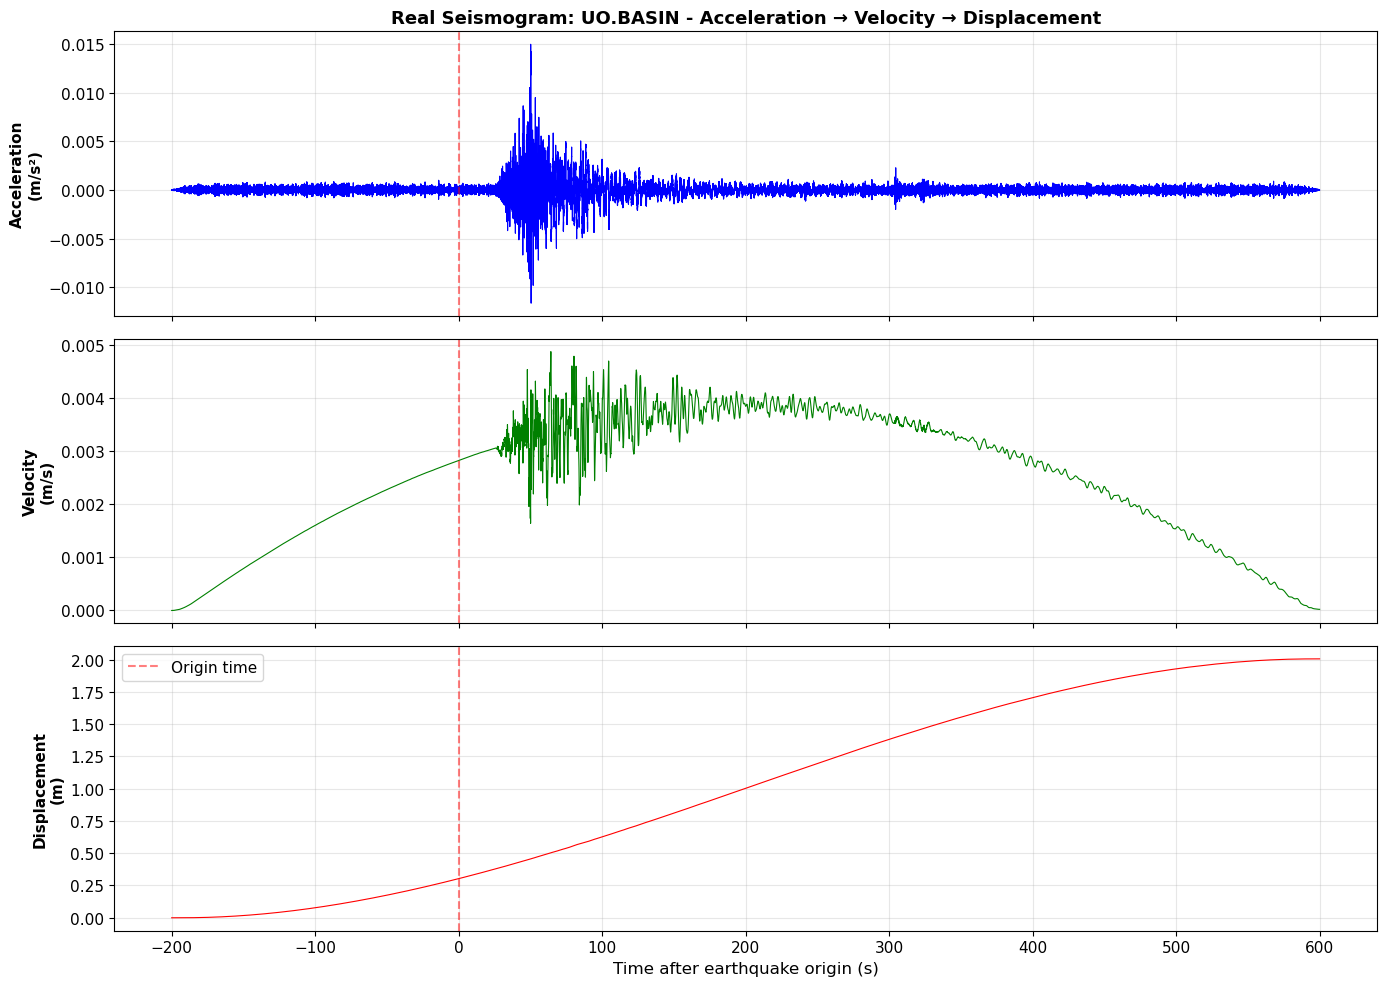

Observations (compare to toy problem):
1. Integration smooths the signal (removes high frequencies)
2. Displacement shows longer-period motion
3. Peak acceleration ≠ peak displacement!

   Peak acceleration: 0.0150 m/s²
   Peak velocity: 0.0049 m/s
   Peak displacement: 2.0051 m


In [27]:
# Get the data arrays
acc_data = tr_acc.data
dt = tr_acc.stats.delta  # Time step

# Integrate to get velocity
vel_data = cumulative_trapezoid(acc_data, dx=dt, initial=0)

# Integrate again to get displacement
disp_data = cumulative_trapezoid(vel_data, dx=dt, initial=0)

# Plot all three
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

time_rel = tr_acc.times(reftime=t0)

# Acceleration
axes[0].plot(time_rel, acc_data, 'b-', linewidth=0.8)
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Acceleration\n(m/s²)', fontsize=11, fontweight='bold')
axes[0].set_title(f'Real Seismogram: {network}.{station} - Acceleration → Velocity → Displacement', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Velocity
axes[1].plot(time_rel, vel_data, 'g-', linewidth=0.8)
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Velocity\n(m/s)', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Displacement
axes[2].plot(time_rel, disp_data, 'r-', linewidth=0.8)
axes[2].axvline(0, color='red', linestyle='--', alpha=0.5, label='Origin time')
axes[2].set_ylabel('Displacement\n(m)', fontsize=11, fontweight='bold')
axes[2].set_xlabel('Time after earthquake origin (s)', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observations (compare to toy problem):")
print("1. Integration smooths the signal (removes high frequencies)")
print("2. Displacement shows longer-period motion")
print("3. Peak acceleration ≠ peak displacement!")
print(f"\n   Peak acceleration: {np.max(np.abs(acc_data)):.4f} m/s²")
print(f"   Peak velocity: {np.max(np.abs(vel_data)):.4f} m/s")
print(f"   Peak displacement: {np.max(np.abs(disp_data)):.4f} m")

### 2.7 Fourier Analysis of Real Seismograms

Now let's look at the **spectral content** - what frequencies are in this earthquake signal?

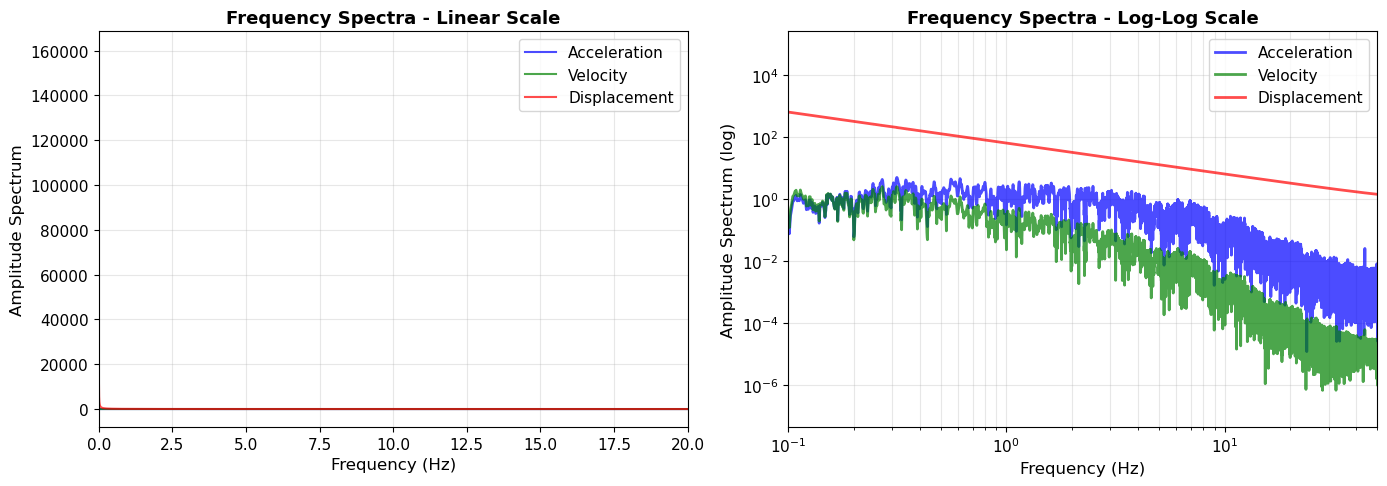

Dominant frequency: 0.31 Hz (period = 3.17 s)

Observations:
1. Earthquake energy concentrated in 0.5-10 Hz range
2. Spectra show characteristic 1/f relationship between acc, vel, disp
3. Low frequencies (< 1 Hz) dominate displacement
4. High frequencies (> 5 Hz) dominate acceleration


In [28]:
# Compute Fourier transforms
N_real = len(acc_data)
Acc_fft = np.abs(fft(acc_data)[:N_real//2])
Vel_fft = np.abs(fft(vel_data)[:N_real//2])
Disp_fft = np.abs(fft(disp_data)[:N_real//2])

# Frequency axis
freqs_real = fftfreq(N_real, dt)[:N_real//2]

# Plot spectra
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(freqs_real, Acc_fft, 'b-', linewidth=1.5, label='Acceleration', alpha=0.7)
ax1.plot(freqs_real, Vel_fft, 'g-', linewidth=1.5, label='Velocity', alpha=0.7)
ax1.plot(freqs_real, Disp_fft, 'r-', linewidth=1.5, label='Displacement', alpha=0.7)
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Amplitude Spectrum', fontsize=12)
ax1.set_title('Frequency Spectra - Linear Scale', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 20])

# Log-log scale (easier to see pattern)
ax2.loglog(freqs_real[1:], Acc_fft[1:], 'b-', linewidth=2, label='Acceleration', alpha=0.7)
ax2.loglog(freqs_real[1:], Vel_fft[1:], 'g-', linewidth=2, label='Velocity', alpha=0.7)
ax2.loglog(freqs_real[1:], Disp_fft[1:], 'r-', linewidth=2, label='Displacement', alpha=0.7)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Amplitude Spectrum (log)', fontsize=12)
ax2.set_title('Frequency Spectra - Log-Log Scale', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_xlim([0.1, 50])

plt.tight_layout()
plt.show()

# Find dominant frequency
peak_idx = np.argmax(Acc_fft[freqs_real > 0.1])  # Ignore DC component
peak_freq = freqs_real[freqs_real > 0.1][peak_idx]

print(f"Dominant frequency: {peak_freq:.2f} Hz (period = {1/peak_freq:.2f} s)")
print("\nObservations:")
print("1. Earthquake energy concentrated in 0.5-10 Hz range")
print("2. Spectra show characteristic 1/f relationship between acc, vel, disp")
print("3. Low frequencies (< 1 Hz) dominate displacement")
print("4. High frequencies (> 5 Hz) dominate acceleration")

### 2.6 Applying Tapering to Real Seismic Data

Now let's apply the tapering concepts from Part 1 to our **real earthquake data**. Recall from the toy problems that tapering is crucial for:
1. **Computing spectra** (prevents spectral leakage)
2. **Filtering** (prevents edge ringing)
3. **Differentiating/integrating** (prevents artifact amplification)

We'll extract a window from our acceleration data and demonstrate all three applications. Real seismic records rarely start and end at zero, so edge artifacts can severely contaminate your analysis without proper tapering.

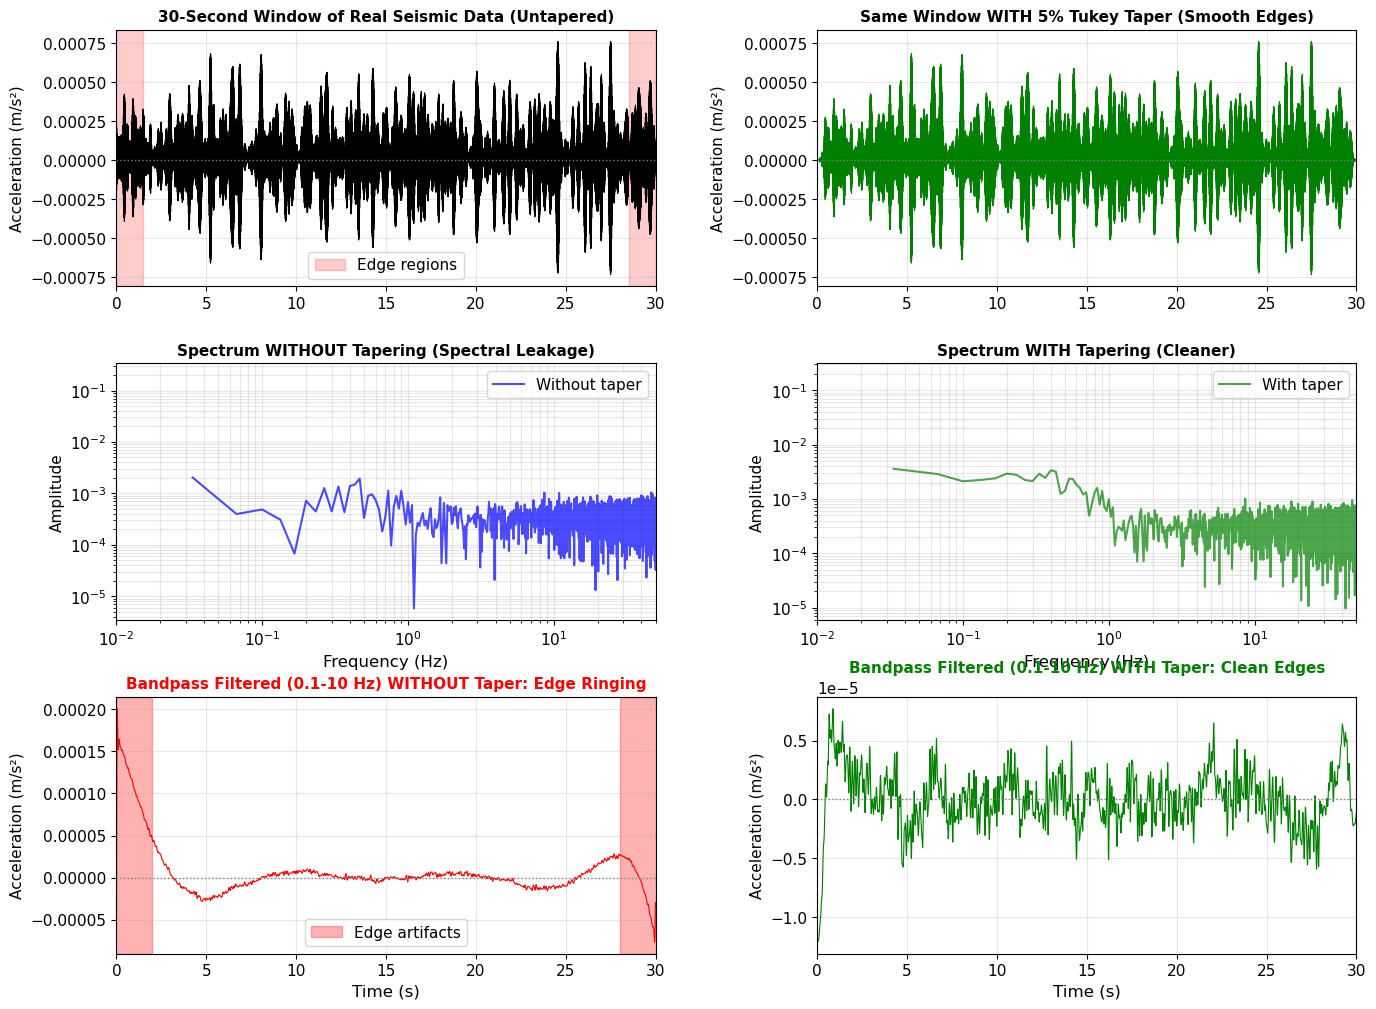

Real seismic data analysis:
  Original window: 6000 samples (30.0 seconds)
  Sampling rate: 200.0 Hz
  Start value: -2.186170e-04 m/s²
  End value: 6.388503e-05 m/s²
  → Discontinuity: 2.825020e-04 m/s²

✅ Best practice: ALWAYS taper before:
   - Computing spectra
   - Filtering
   - Differentiating/integrating
   - Cross-correlating

⚠️  Exception: When analyzing the full continuous record with proper DC removal.

💡 Notice: Same tapering principles from toy problems apply perfectly to real data!


In [29]:
# Extract a 30-second window from the real acceleration data
# This simulates analyzing a portion of a seismogram
start_idx = 5000  # Start somewhere in the middle
window_length = int(30 * tr_acc.stats.sampling_rate)  # 30 seconds
data_window = tr_acc.data[start_idx:start_idx + window_length]
time_window = np.arange(len(data_window)) / tr_acc.stats.sampling_rate

# Compute spectra WITHOUT and WITH tapering
# WITHOUT taper
fft_notaper = np.fft.rfft(data_window)
freqs_real = np.fft.rfftfreq(len(data_window), 1/tr_acc.stats.sampling_rate)
spectrum_notaper = np.abs(fft_notaper)

# WITH taper (5% Tukey taper - common in seismology)
taper_real = windows.tukey(len(data_window), alpha=0.05)
data_tapered = data_window * taper_real
fft_tapered = np.fft.rfft(data_tapered)
spectrum_tapered = np.abs(fft_tapered)

# Also filter this window to show filtering artifacts
b, a = butter(4, [0.1, 10], btype='band', fs=tr_acc.stats.sampling_rate)
data_filt_notaper = filtfilt(b, a, data_window)
data_filt_withtaper = filtfilt(b, a, data_tapered)

# Create comparison plot
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Row 1: Time domain - original window
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_window, data_window, 'k-', linewidth=0.8)
ax1.axhline(0, color='gray', linestyle=':', linewidth=1)
ax1.axvspan(0, 1.5, alpha=0.2, color='red', label='Edge regions')
ax1.axvspan(28.5, 30, alpha=0.2, color='red')
ax1.set_ylabel('Acceleration (m/s²)', fontsize=11)
ax1.set_title('30-Second Window of Real Seismic Data (Untapered)', fontsize=11, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 30])

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time_window, data_tapered, 'g-', linewidth=0.8)
ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
ax2.set_ylabel('Acceleration (m/s²)', fontsize=11)
ax2.set_title('Same Window WITH 5% Tukey Taper (Smooth Edges)', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 30])

# Row 2: Frequency domain - spectra
ax3 = fig.add_subplot(gs[1, 0])
ax3.loglog(freqs_real[1:], spectrum_notaper[1:], 'b-', linewidth=1.5, alpha=0.7, label='Without taper')
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_xlabel('Frequency (Hz)', fontsize=12)
ax3.set_title('Spectrum WITHOUT Tapering (Spectral Leakage)', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, which='both')
ax3.set_xlim([0.01, 50])

ax4 = fig.add_subplot(gs[1, 1])
ax4.loglog(freqs_real[1:], spectrum_tapered[1:], 'g-', linewidth=1.5, alpha=0.7, label='With taper')
ax4.set_ylabel('Amplitude', fontsize=11)
ax4.set_xlabel('Frequency (Hz)', fontsize=12)
ax4.set_title('Spectrum WITH Tapering (Cleaner)', fontsize=11, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, which='both')
ax4.set_xlim([0.01, 50])

# Row 3: Filtered data comparison
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(time_window, data_filt_notaper, 'r-', linewidth=0.8)
ax5.axhline(0, color='gray', linestyle=':', linewidth=1)
ax5.axvspan(0, 2, alpha=0.3, color='red', label='Edge artifacts')
ax5.axvspan(28, 30, alpha=0.3, color='red')
ax5.set_ylabel('Acceleration (m/s²)', fontsize=11)
ax5.set_xlabel('Time (s)', fontsize=12)
ax5.set_title('Bandpass Filtered (0.1-10 Hz) WITHOUT Taper: Edge Ringing', fontsize=11, fontweight='bold', color='red')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_xlim([0, 30])

ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(time_window, data_filt_withtaper, 'g-', linewidth=0.8)
ax6.axhline(0, color='gray', linestyle=':', linewidth=1)
ax6.set_ylabel('Acceleration (m/s²)', fontsize=11)
ax6.set_xlabel('Time (s)', fontsize=12)
ax6.set_title('Bandpass Filtered (0.1-10 Hz) WITH Taper: Clean Edges', fontsize=11, fontweight='bold', color='green')
ax6.grid(True, alpha=0.3)
ax6.set_xlim([0, 30])

plt.show()

print("Real seismic data analysis:")
print(f"  Original window: {len(data_window)} samples ({len(data_window)/tr_acc.stats.sampling_rate:.1f} seconds)")
print(f"  Sampling rate: {tr_acc.stats.sampling_rate} Hz")
print(f"  Start value: {data_window[0]:.6e} m/s²")
print(f"  End value: {data_window[-1]:.6e} m/s²")
print(f"  → Discontinuity: {abs(data_window[-1] - data_window[0]):.6e} m/s²")
print("\n✅ Best practice: ALWAYS taper before:")
print("   - Computing spectra")
print("   - Filtering")
print("   - Differentiating/integrating")
print("   - Cross-correlating")
print("\n⚠️  Exception: When analyzing the full continuous record with proper DC removal.")
print("\n💡 Notice: Same tapering principles from toy problems apply perfectly to real data!")

---

## Summary: Theory Meets Observation

We started with **toy problems** using simple sinusoids to understand:
- Fourier transform decomposes signals into frequencies
- Time domain ↔ Frequency domain are equivalent views
- Integration divides spectrum by frequency (suppresses high freq)
- Differentiation multiplies spectrum by frequency (enhances high freq)

Then we applied these concepts to **real seismic data**:
- Downloaded earthquake recordings from IRIS
- Removed instrument response to get ground motion
- Integrated acceleration → velocity → displacement
- Analyzed spectral content with Fourier transforms

**Key Takeaways:**
1. **Same physics in toy problems and real earthquakes!**
2. **Frequency analysis reveals what simple time-domain inspection cannot**
3. **Choice of ground motion unit (acc/vel/disp) depends on application:**
   - Engineering (building response) → Acceleration
   - Long-period seismology (Earth structure) → Displacement/Velocity
   - Magnitude determination → Often velocity or displacement

---

### Next Steps

In future notebooks, we'll use these Fourier analysis skills for:
- **Filtering**: Isolating specific frequency bands (body waves vs surface waves)
- **Spectrograms**: Time-frequency analysis of dispersive waves
- **Transfer functions**: Relating input to output through Earth's structure

The Fourier transform is your most important tool in seismology - master it!